<a href="https://colab.research.google.com/github/nav500/food-vision/blob/main/food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food vision

This project uses transfer learning to identify foods from images. The model is built in tensorflow.

## Objectives

* Explore data
* Build and train model
* Analyze accuracy of the model

## Check GPU

In [ ]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f3f72835-7524-4f9c-c613-f386a2cfd535)


## Dataset

The model will use `food101` dataset available in tensorflow datasets for training. This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images.

In [17]:
import tensorflow_datasets as tfds
import tensorflow as tf

(train_ds, test_ds), data_info = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=False,
    as_supervised=True,
    with_info=True
)

## Explore data

In [3]:
data_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo n

Extracting the class labels.

In [5]:
class_labels = data_info.features["label"].names
print("Number of classes: ", len(class_labels))
print("Example class names: ", class_labels[:10])

Number of classes:  101
Example class names:  ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [6]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
img, label = next(iter(train_ds.take(1)))

In [8]:
print("Image shape: ", img.shape)
print("Image type: ", img.dtype)
print("Label: ", label.numpy())
print("Label name: ", class_labels[label])

Image shape:  (512, 512, 3)
Image type:  <dtype: 'uint8'>
Label:  56
Label name:  huevos_rancheros


Running the above cell multiple times confirm that images in the dataset have different width and hieghts.

## Visualizing data

(-0.5, 511.5, 511.5, -0.5)

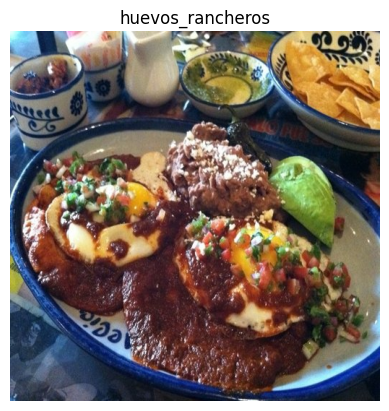

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(class_labels[label])
plt.axis(False)

## Preprocessing data

Steps to perform to preprocess images

* uint8 to float32 conversion of image pixel values
* resize height and width of images to 224x224

In [18]:
def preprocess_image(img, label, img_size=224):
  img = tf.image.resize(img, [img_size, img_size])
  img = tf.cast(img, tf.float32)
  return img, label

In [19]:
preprocessed_img_label = preprocess_image(img, label)

In [20]:
preprocessed_img_label[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[139.00893 , 146.82588 , 157.64285 ],
        [142.      , 148.      , 160.      ],
        [144.67316 , 148.70822 , 164.18399 ],
        ...,
        [145.31506 , 140.88654 , 138.52933 ],
        [143.36607 , 140.36607 , 135.36607 ],
        [145.5836  , 142.5836  , 137.5836  ]],

       [[142.13329 , 148.54497 , 157.64285 ],
        [143.09822 , 149.13744 , 161.05899 ],
        [142.66518 , 149.23534 , 166.74107 ],
        ...,
        [142.35136 , 137.92284 , 135.56563 ],
        [145.58833 , 142.58833 , 137.58833 ],
        [144.96072 , 141.96072 , 136.96072 ]],

       [[146.69101 , 151.11607 , 156.98917 ],
        [145.96109 , 151.83641 , 163.62819 ],
        [142.93335 , 151.45503 , 170.97673 ],
        ...,
        [142.36188 , 137.93335 , 135.57614 ],
        [145.15627 , 142.15627 , 137.15627 ],
        [144.66705 , 141.66705 , 136.66705 ]],

       ...,

       [[146.55801 , 143.55801 , 154.55801 ],
        [149.

(-0.5, 223.5, 223.5, -0.5)

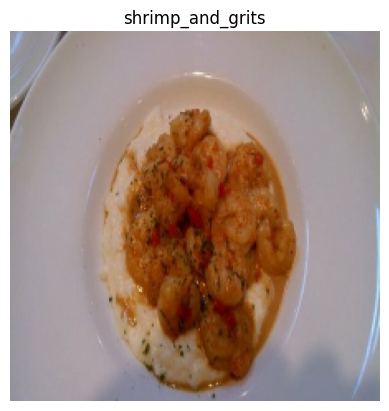

In [21]:
plt.imshow(preprocessed_img_label[0]/255)
plt.title(class_labels[preprocessed_img_label[1].numpy()])
plt.axis(False)

In [22]:
preprocessed_img_label[1]

<tf.Tensor: shape=(), dtype=int64, numpy=89>

In [23]:
preprocessed_img_label[1]

<tf.Tensor: shape=(), dtype=int64, numpy=89>

In [24]:
# apply the preprocessing to the entire train set
train_ds = train_ds.map(map_func=preprocess_image)

# create batches of data in the train set
train_ds = train_ds.shuffle(buffer_size=32, reshuffle_each_iteration=False).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# repeat the above steps for test set
test_ds = test_ds.map(map_func=preprocess_image)
test_ds = test_ds.shuffle(buffer_size=32, reshuffle_each_iteration=False).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


## Model checkpoint callback

In [ ]:
feature_ext_cpt_path = "model_checkpoints/feature_extractor/feature_extractor_checkpoint"

def create_model_checkpoint(dirname, experiment_name):
  feature_ext_cpt_path = f"model_checkpoints/{experiment_name}/{experiment_name}_checkpoint"
  feature_ext_cpt = tf.keras.callbacks.ModelCheckpoint(
      feature_ext_cpt_path,
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True,
      save_weights_only=True
  )
  return feature_ext_cpt

## Tensorboard callback

In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Setting mixed precision

Mixed precision will use combination of float 16 and float 32 whenever possible to speed up the executions.

In [ ]:
tf.keras.mixed_precision.set_global_policy(policy="mixed_float16")

## Build feature extractor model

### Prepare the model

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False,
)

base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(input_layer)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
x = tf.keras.layers.Dense(len(class_labels))(x)
output = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_activation")(x)

model = tf.keras.Model(input_layer, output)

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool (GlobalAve  (None, 1280)              0         
 ragePooling2D)                                                  
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_activation (Activa  (None, 101)               0         
 tion)                                                           
                                                             

In [ ]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
for layer in model.layers:
  print(f"{layer.name}, {layer.dtype}, {layer.dtype_policy}")

input_layer, float32, <Policy "float32">
efficientnetv2-b0, float32, <Policy "mixed_float16">
global_avg_pool, float32, <Policy "mixed_float16">
dense, float32, <Policy "mixed_float16">
softmax_activation, float32, <Policy "float32">


### Fit the model

In [ ]:
feature_ext_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    validation_steps=int(0.15*len(test_ds)),
    callbacks=[
        create_model_checkpoint("checkpoints", "feature_extractor"),
        create_tensorboard_callback("tensorboard", "feature_extractor")
        ]
)

Saving TensorBoard log files to: tensorboard/feature_extractor/20230919-080319
Epoch 1/10
2368/2368 [==============================] - 242s 102ms/step - loss: 1.3205 - accuracy: 0.6587 - val_loss: 1.0458 - val_accuracy: 0.7196
Epoch 2/10
2368/2368 [==============================] - 198s 83ms/step - loss: 1.1850 - accuracy: 0.6914 - val_loss: 1.0007 - val_accuracy: 0.7284
Epoch 3/10
2368/2368 [==============================] - 236s 99ms/step - loss: 1.1032 - accuracy: 0.7103 - val_loss: 0.9742 - val_accuracy: 0.7358
Epoch 4/10
2368/2368 [==============================] - 234s 98ms/step - loss: 1.0389 - accuracy: 0.7262 - val_loss: 0.9627 - val_accuracy: 0.7380
Epoch 5/10
2368/2368 [==============================] - 203s 85ms/step - loss: 0.9921 - accuracy: 0.7347 - val_loss: 0.9496 - val_accuracy: 0.7397
Epoch 6/10
2368/2368 [==============================] - 239s 101ms/step - loss: 0.9524 - accuracy: 0.7459 - val_loss: 0.9409 - val_accuracy: 0.7431
Epoch 7/10
2368/2368 [===============

### Feature extractor model accuracy

In [ ]:
model.evaluate(test_ds)

790/790 [==============================] - 49s 62ms/step - loss: 0.9432 - accuracy: 0.7414


[0.9432175159454346, 0.7414257526397705]

The feature extractor model has arount 74% accuracy.

## Save the model

In [ ]:
!mkdir -p saved_models

In [ ]:
model.save("/content/saved_models/feature_extractor.keras")

In [ ]:
!zip -r /content/feature_extractor_checkpoints.zip /content/model_checkpoints/feature_extractor

  adding: content/model_checkpoints/feature_extractor/ (stored 0%)
  adding: content/model_checkpoints/feature_extractor/feature_extractor_checkpoint.data-00000-of-00001 (deflated 8%)
  adding: content/model_checkpoints/feature_extractor/feature_extractor_checkpoint.index (deflated 78%)
  adding: content/model_checkpoints/feature_extractor/checkpoint (deflated 50%)


## Clone the model with feature extractor and load the checkpoints

In [ ]:
feature_extractor = tf.keras.models.clone_model(
    model
)

feature_extractor.load_weights("/content/model_checkpoints/feature_extractor/feature_extractor_checkpoint")

## Fine tuning model

Let's fine tune the model to increase accuracy.

Make the base model trainable and then compile the main model.

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    metrics=["accuracy"]
)

Fit the data to fine tune model.

In [ ]:
fine_tuned_history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=[
        create_model_checkpoint("checkpoints", "fined_tuned_checkpoint"),
        create_tensorboard_callback("tensorboard", "fined_tuned_model")
    ]
)

Saving TensorBoard log files to: tensorboard/fined_tuned_model/20230919-085430
Epoch 1/5
2368/2368 [==============================] - 221s 87ms/step - loss: 1.0527 - accuracy: 0.7109 - val_loss: 0.8804 - val_accuracy: 0.7575
Epoch 2/5
2368/2368 [==============================] - 239s 101ms/step - loss: 0.8004 - accuracy: 0.7757 - val_loss: 0.8433 - val_accuracy: 0.7679
Epoch 3/5
2368/2368 [==============================] - 239s 101ms/step - loss: 0.6651 - accuracy: 0.8115 - val_loss: 0.8374 - val_accuracy: 0.7706
Epoch 4/5
2368/2368 [==============================] - 240s 101ms/step - loss: 0.5691 - accuracy: 0.8375 - val_loss: 0.8352 - val_accuracy: 0.7748
Epoch 5/5
2368/2368 [==============================] - 201s 85ms/step - loss: 0.4905 - accuracy: 0.8603 - val_loss: 0.8326 - val_accuracy: 0.7756


In [ ]:
!zip -r /content/fined_tuned_checkpoint.zip /content/model_checkpoints/fined_tuned_checkpoint

  adding: content/model_checkpoints/fined_tuned_checkpoint/ (stored 0%)
  adding: content/model_checkpoints/fined_tuned_checkpoint/fined_tuned_checkpoint_checkpoint.data-00000-of-00001 (deflated 8%)
  adding: content/model_checkpoints/fined_tuned_checkpoint/fined_tuned_checkpoint_checkpoint.index (deflated 78%)
  adding: content/model_checkpoints/fined_tuned_checkpoint/checkpoint (deflated 58%)


In [ ]:
model.evaluate(test_ds)

790/790 [==============================] - 50s 63ms/step - loss: 0.8326 - accuracy: 0.7756


[0.8326212167739868, 0.7756039500236511]

So the model has now over 77% accuracy!

### Save the fine tuned model

In [14]:
!mkdir -p saved_models

In [ ]:
model.save("/content/saved_models/fined_tuned_model.keras")

## Performance evaluation

In [14]:
# load the model
fine_tuned_model = tf.keras.models.load_model("/content/saved_models/fined_tuned_model.keras")

In [26]:
import numpy as np

true_labels = []

for img, label in test_ds.unbatch():
  true_labels.append(label.numpy())

true_labels = np.array(true_labels)
print(true_labels[:10])

[ 53  29  40  10 100  40  44  32  29  97]


In [27]:
predict_labels = fine_tuned_model.predict(test_ds)

790/790 [==============================] - 72s 79ms/step


In [28]:
predict_labels = tf.argmax(predict_labels, axis=1).numpy()

In [29]:
predict_labels

array([53, 29, 40, ..., 86, 94, 84])

In [30]:
np.sum(predict_labels == true_labels)/len(true_labels)

0.7756039603960396

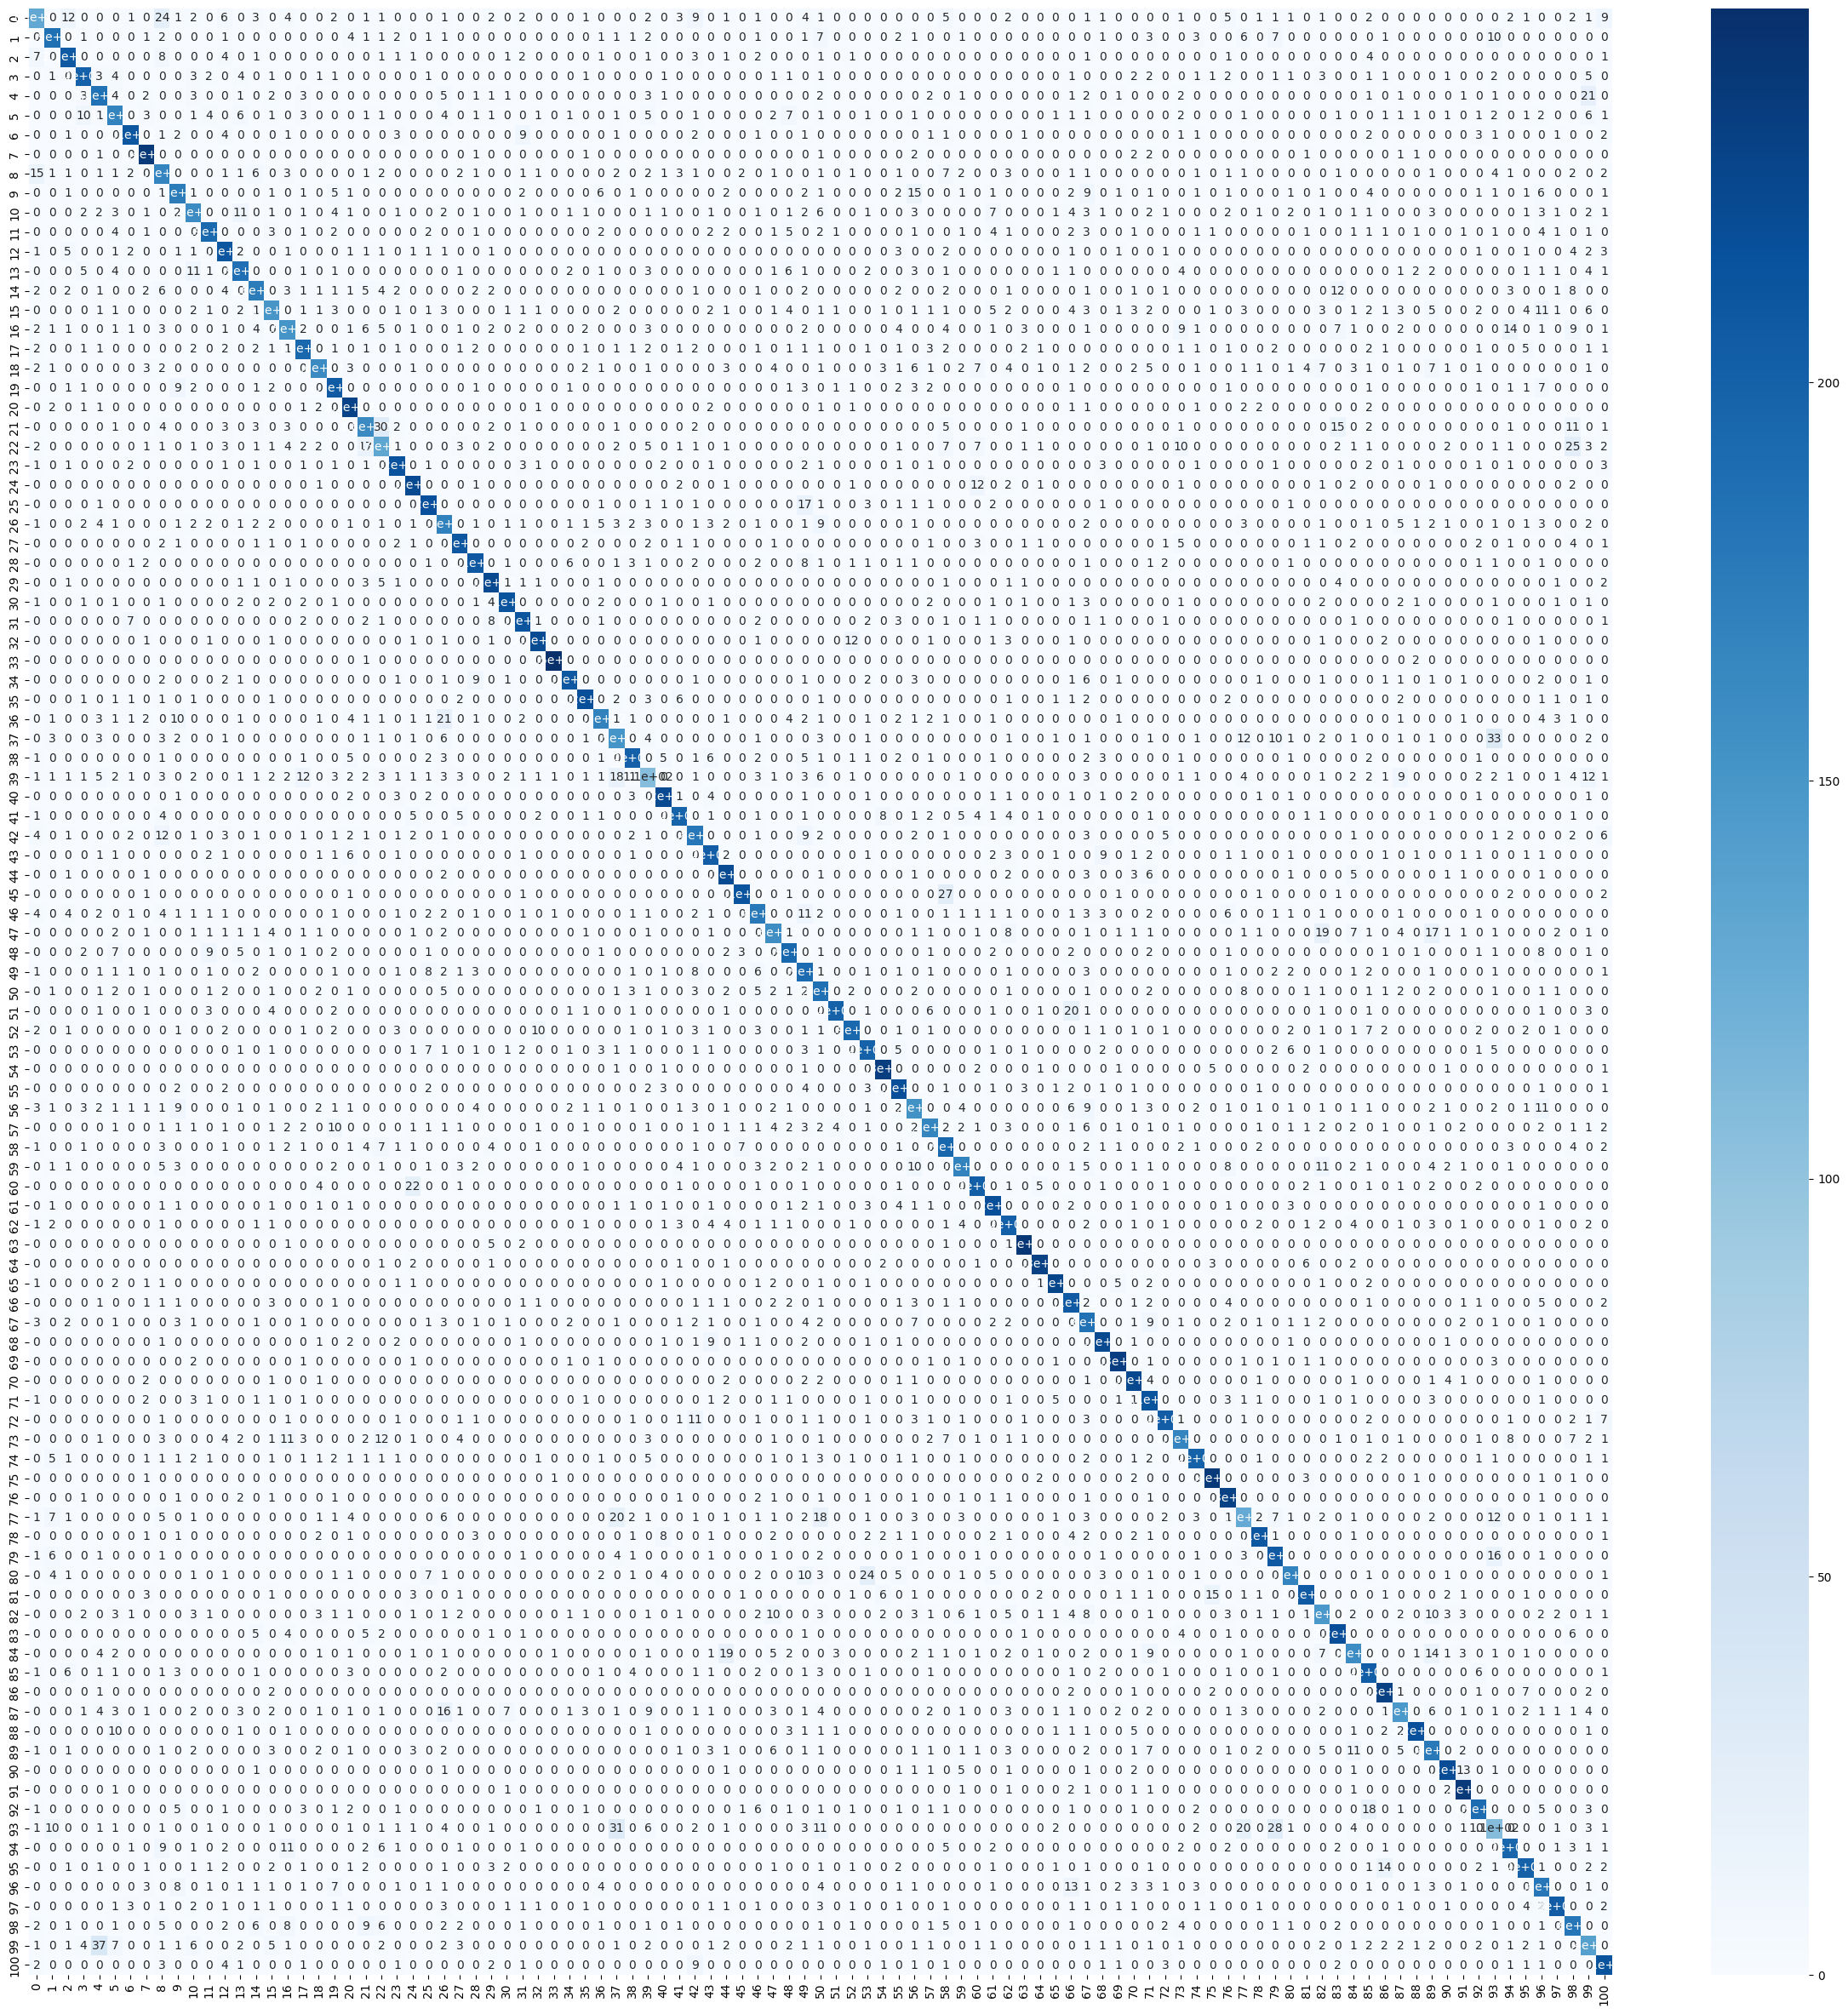

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns



confusion_matrix = confusion_matrix(true_labels, predict_labels)


plt.figure(figsize=(30,30))
ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

The confusion matrix help us visualize the most misclassified categories.